In [4]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This notebook demonstrates a 'retrieve and rank' approach to new product categorization.

It consists of the following steps, each of which is expanded upon in the respective sections below:

1. Embed product description and image

2. **Retrieve** nearest neighbors in embedding space

3. Fetch corresponding categories for nearest neighbors

4. Feed categories as as candidates to an LLM, ask it to **rank** by relevance to user input product description

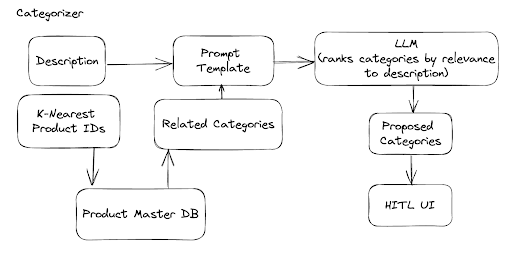

# Motivation

When a new product is added to inventory at a retailer it gets added to a product catalog. Correct placement in a catalog can impact which customers find or are presented with the product - ultimately impacting sales. Building a model that can turn product descriptions and images into correct categorization within a product catalog can help automate product placement.

# Setup

### Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [5]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Authenticate

If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

If you are using Vertex AI Workbench, you will not require additional authentication.

In [7]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

### Config

Update the below variables to point the Vector DB and BigQuery table you created in the previous notebooks

In [8]:
# GCP
PROJECT = 'solutions-2023-mar-107' # @param {type:"string"} 
LOCATION = 'us-central1' # @param {type:"string"}

# Vertex Vector Store
ENDPOINT_ID = '1641918305943945216' # @param {type:"string"} # @param {type:"string"}
DEPLOYED_INDEX_ID = 'flipkart_streaming_filteri_1702030773989' # @param {type:"string"} # @param {type:"string"}
NUM_NEIGHBORS = 7 # Fetches NUM_NEIGBHORS for both text and image embeddings

# BigQuery
MASTER_PRODUCT_TABLE = 'solutions-2023-mar-107.flipkart.18K_no_duplicate' # @param {type:"string"}
TEST_SET_TABLE = 'solutions-2023-mar-107.flipkart.flipkart_golden_test' # @param {type:"string"}

#Test Item
DESCRIPTION = "Solemio Sleeveless Solid Men's Reversible Sweatshirt Price: Rs. 1,261 Fitz Blue Sweat Shirt is a must-have for any wardrobe. Ensemble with trendy embroidery on the chest and full zipped closure down front. It is marked with ribbed waistband, cuffs and two pouch pockets on the front. Classic color scheme allows you to wear this over a wide range of separates. Relaxed fit for free body movement. Brand: Fitz Color: Red Style Statement: Designed to be worn as casual as well as leisure wear. Team it with a denims and sneakers to look uber cool. Material: Polyester Cotton Wash Care: Do not bleach and tumble dry. Use gentle machine wash and gentle warm Iron. About the brand: FITZ is the company’s flagship sportswear and active wear brand with an Indian soul and international outlook. It is an evolved range of sports and activity gears dedicated to sports enthusiasts. The brand is poised to become an economic force when it comes to young people who are aware of style trends, sportswear designs reflected the spirited, celebrity-conscious sensibilities of the decade. Disclaimer: Product color may slightly vary due to photographic lighting sources or your monitor settings. Size varies from brand to brand. Kindly go through the size chart for more clarity. Fitz Blue Sweat Shirt is a must-have for any wardrobe. Ensemble with trendy embroidery on the chest and full zipped closure down front. It is marked with ribbed waistband, cuffs and two pouch pockets on the front. Classic color scheme allows you to wear this over a wide range of separates. Relaxed fit for free body movement. Brand: Fitz Color: Red Style Statement: Designed to be worn as casual as well as leisure wear. Team it with a denims and sneakers to look uber cool. Material: Polyester Cotton Wash Care: Do not bleach and tumble dry. Use gentle machine wash and gentle warm Iron. About the brand: FITZ is the company’s flagship sportswear and active wear brand with an Indian soul and international outlook. It is an evolved range of sports and activity gears dedicated to sports enthusiasts. The brand is poised to become an economic force when it comes to young people who are aware of style trends, sportswear designs reflected the spirited, celebrity-conscious sensibilities of the decade. Disclaimer: Product color may slightly vary due to photographic lighting sources or your monitor settings. Size varies from brand to brand. Kindly go through the size chart for more clarity."
IMAGE_URL='gs://genai-product-catalog/flipkart_20k_oct26/cc38a2f5be7275d9c0c80fb27c73b03d_0.jpg'

# 1. Embed

The system will use multimodal embeddings to create a semantic vector representations of the product description and product image. We leverage the [Vertex AI Embedding API](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-image-embeddings) for this.

It is important to note that text and image data is not fused into a single embedding. The service provides text-only and image-only embeddings, but they share an embedding space. In other words the text 'cat' and a picture of a cat should return similar embeddings.

In [9]:
import sys; sys.path.insert(0, '../backend/')
import embeddings # Local Project Code
emb = embeddings.embed(DESCRIPTION[:1022],IMAGE_URL,project=PROJECT)

print(emb.text_embedding[:5])
print(emb.image_embedding[:5])

[-0.0193069521, -0.0572998524, 0.00424724212, -8.67597337e-05, 0.0197201408]
[-0.0210017916, 0.0108621027, 0.00487905415, -0.00592259737, 0.0153212873]


# 2. Fetch K Nearest Neighbors

This notebooks assumes a Vertex Vector Search Index with product image and text embeddings is already deployed. For instructions on that see 2_create_vector_db.ipynb

Note at inference time we may be provided an image, a description, or both. This will result in 1-2 embeddings, and we will return the nearest neighbors for each. Because images and text share an embedding space, images can be used to find related text and and text and be used to find related images.

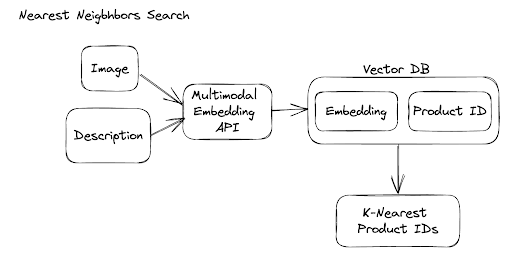



In [10]:
from google.cloud import aiplatform

my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name=ENDPOINT_ID,
    project=PROJECT,
    location=LOCATION
)

In [11]:
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='7894b144578e1fdc2a0e03c5dce2427c_T', distance=0.28414440155029297),
  MatchNeighbor(id='0f9b331bc9400474e182878acfab218b_T', distance=0.32767146825790405),
  MatchNeighbor(id='385f0e4a73307f8eb0992a4dfdca9471_T', distance=0.3276839256286621),
  MatchNeighbor(id='5c28a80aaa4f12cca8926d84a1130ce1_T', distance=0.3276839256286621),
  MatchNeighbor(id='bc71140c796df3a05d4120882cb42ad3_T', distance=0.3276839256286621),
  MatchNeighbor(id='decad654beb9df92b93de4b3b8dba682_T', distance=0.3276839256286621),
  MatchNeighbor(id='e6fab8e1e818f3495a6aa120951cd6a1_T', distance=0.3276839256286621)],
 [MatchNeighbor(id='7fa70dc893d98d8a9f43bb86b480b5a7_I', distance=0.17684012651443481),
  MatchNeighbor(id='759f5b9ff6067be78f181b75e493e48d_I', distance=0.17842066287994385),
  MatchNeighbor(id='86e653e4064c99f4a8ec1726c0dba5b9_I', distance=0.2164071798324585),
  MatchNeighbor(id='ace9a22e2087870c2f223a9c55e41186_I', distance=0.22416085004806519),
  MatchNeighbor(id='62e66eabd4db0e5d0

# 3. Join Category

The Vector DB does not contain reference information such as category. It only returns a product ID. We join this against the master product reference table in BigQuery

In [12]:
from google.cloud import bigquery
bq_client = bigquery.Client(PROJECT)

ids = [r.id[:-2] for neighbor in response for r in neighbor]
query = f"""
SELECT
  uniq_id,
  c0_name,
  c1_name,
  c2_name,
  c3_name
FROM
  `{MASTER_PRODUCT_TABLE}`
WHERE
  uniq_id IN {str(ids).replace('[','(').replace(']',')')}
"""
query_job = bq_client.query(query)
rows = query_job.result()
categories = {}
for row in rows:
    categories[row['uniq_id']] = [row['c0_name'],row['c1_name'],row['c2_name'],row['c3_name']]
categories

{'385f0e4a73307f8eb0992a4dfdca9471': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Sweatshirts'],
 'bc71140c796df3a05d4120882cb42ad3': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Sweatshirts'],
 '000908502cb76d87774f769ff431606d': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Sweatshirts'],
 '7894b144578e1fdc2a0e03c5dce2427c': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Sweatshirts'],
 'decad654beb9df92b93de4b3b8dba682': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Sweatshirts'],
 'e6fab8e1e818f3495a6aa120951cd6a1': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Sweatshirts'],
 '86e653e4064c99f4a8ec1726c0dba5b9': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Sweaters'],
 'ace9a22e2087870c2f223a9c55e41186': ['Clothing',
  "Men's Clothing",
  'Winter & Seasonal Wear',
  'Jackets'],
 '62e66eabd4db0e5d0258a5c2db916f61': ['Clothing',
  "Men's Clothing",
  'Winter

In [13]:
# Sort results by embedding distance
candidates = [{'category':categories[r.id[:-2]],'id':r.id, 'distance':r.distance} for neighbor in response for r in neighbor]
sorted(candidates, key=lambda d: d['distance'])

[{'category': ['Clothing',
   "Men's Clothing",
   'Winter & Seasonal Wear',
   'Jackets'],
  'id': '7fa70dc893d98d8a9f43bb86b480b5a7_I',
  'distance': 0.17684012651443481},
 {'category': ['Clothing',
   "Men's Clothing",
   'Winter & Seasonal Wear',
   'Sweatshirts'],
  'id': '759f5b9ff6067be78f181b75e493e48d_I',
  'distance': 0.17842066287994385},
 {'category': ['Clothing',
   "Men's Clothing",
   'Winter & Seasonal Wear',
   'Sweaters'],
  'id': '86e653e4064c99f4a8ec1726c0dba5b9_I',
  'distance': 0.2164071798324585},
 {'category': ['Clothing',
   "Men's Clothing",
   'Winter & Seasonal Wear',
   'Jackets'],
  'id': 'ace9a22e2087870c2f223a9c55e41186_I',
  'distance': 0.22416085004806519},
 {'category': ['Clothing',
   "Men's Clothing",
   'Winter & Seasonal Wear',
   'Jackets'],
  'id': '62e66eabd4db0e5d0258a5c2db916f61_I',
  'distance': 0.24730926752090454},
 {'category': ['Clothing',
   "Men's Clothing",
   'Winter & Seasonal Wear',
   'Sweatshirts'],
  'id': '998626f7d4d23095d9c9f

# 4. Benchmark

Now that we've demonstrated vector based retrieval on a single example, let's evaluate the approach using our golden test set containing ~100 examples.

The items in the test set are excluded from the vector database to simulate these being new/unkown items.



## Download Test Set

In [14]:
query = f"""
  SELECT
    id,
    description,
    image_uri,
    c0_name,
    c1_name,
    c2_name,
    c3_name,
    train_val_count
  FROM
    `{TEST_SET_TABLE}`
  WHERE
    manual_validation = 1 AND
    train_val_count >= 1
"""
df = bq_client.query(query).to_dataframe()

In [15]:
df.head()

,id,description,image_uri,c0_name,c1_name,c2_name,c3_name,train_val_count
0,dbdac18a8ee5a8a48238b9685c96e90a,Timewel 1100-N1949_S Analog Watch - For Women ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Timewel Wrist Watches,None,1
1,8a771d8dfa97d06278038945dfe6b936,Chappin & Nellson CNL-50-White Analog Watch - ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Chappin & Nellson Wrist Watches,None,1
2,894904e26516d491bf1c7711fe800e78,"Only Kidz 20600 Digital Watch - For Boys, Girl...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Only Kidz Wrist Watches,None,1
3,138f8455457c6cf87a0b94e132c485a8,Gift Island SW13392C Fashionin Digital Watch -...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Gift Island Wrist Watches,None,1
4,7c973b8fb2069b2142aea3473b70c213,"Key Features of Sakhi Styles Men, Boys Materia...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Watch Accessories,Wrist Bands,Sakhi Styles Wrist Bands,1


## Add Labels

In [16]:
CAT_COLS = ['c0_name','c1_name','c2_name','c3_name']
NULL_REPL = 'Other' # fallback if column is null

def merge_category_names(row, cols: list[str], null_repl : str) -> str:
  """Given a row with individual category columns, combine"""
  return [row[col] if row[col] else null_repl for col in cols]

df["y_label"] = df.apply(lambda x: merge_category_names(x, CAT_COLS, NULL_REPL), axis=1)

In [17]:
df.head()

,id,description,image_uri,c0_name,c1_name,c2_name,c3_name,train_val_count,y_label
0,dbdac18a8ee5a8a48238b9685c96e90a,Timewel 1100-N1949_S Analog Watch - For Women ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Timewel Wrist Watches,None,1,"[Watches, Wrist Watches, Timewel Wrist Watches..."
1,8a771d8dfa97d06278038945dfe6b936,Chappin & Nellson CNL-50-White Analog Watch - ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Chappin & Nellson Wrist Watches,None,1,"[Watches, Wrist Watches, Chappin & Nellson Wri..."
2,894904e26516d491bf1c7711fe800e78,"Only Kidz 20600 Digital Watch - For Boys, Girl...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Only Kidz Wrist Watches,None,1,"[Watches, Wrist Watches, Only Kidz Wrist Watch..."
3,138f8455457c6cf87a0b94e132c485a8,Gift Island SW13392C Fashionin Digital Watch -...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Gift Island Wrist Watches,None,1,"[Watches, Wrist Watches, Gift Island Wrist Wat..."
4,7c973b8fb2069b2142aea3473b70c213,"Key Features of Sakhi Styles Men, Boys Materia...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Watch Accessories,Wrist Bands,Sakhi Styles Wrist Bands,1,"[Watches, Watch Accessories, Wrist Bands, Sakh..."


## Get Predictions

Let's combine the embed, retrieval, and category join steps into a single function

In [18]:
def gen_candidates(desc: str, image_uri: str, num_neighbors = 3):
  emb = embeddings.embed(desc,image_uri,project=PROJECT)
  neighbors = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=num_neighbors,
  )
  ids = [r.id[:-2] for neighbor in neighbors for r in neighbor]
  query = f"""
    SELECT
      uniq_id as id,
      c0_name,
      c1_name,
      c2_name,
      c3_name
    FROM
      `{MASTER_PRODUCT_TABLE}`
    WHERE
      uniq_id IN {str(ids).replace('[','(').replace(']',')')}
    """
  query_job = bq_client.query(query)
  rows = query_job.result()
  categories = {}
  for row in rows:
      categories[row['id']] = [row['c0_name'],row['c1_name'],row['c2_name'],row['c3_name']]
  candidates = [{'category':categories[r.id[:-2]],'id':r.id, 'distance':r.distance}
                  for neighbor in neighbors for r in neighbor]
  return sorted(candidates, key=lambda d: d['distance'])

In [19]:
%%time
# Takes ~7 minutes
df["nearest_neighbors"] = df.apply(lambda x: gen_candidates(x['description'][:1000],x['image_uri'], num_neighbors=NUM_NEIGHBORS), axis=1)
df["y_pred_greedy"] = df["nearest_neighbors"].apply(lambda x: x[0]['category'])
df.to_pickle('test_df')
df.head()

CPU times: user 5.51 s, sys: 462 ms, total: 5.97 s
Wall time: 5min 3s


,id,description,image_uri,c0_name,c1_name,c2_name,c3_name,train_val_count,y_label,nearest_neighbors,y_pred_greedy
0,dbdac18a8ee5a8a48238b9685c96e90a,Timewel 1100-N1949_S Analog Watch - For Women ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Timewel Wrist Watches,None,1,"[Watches, Wrist Watches, Timewel Wrist Watches...","[{'category': ['Watches', 'Wrist Watches', 'Ti...","[Watches, Wrist Watches, Timewel Wrist Watches..."
1,8a771d8dfa97d06278038945dfe6b936,Chappin & Nellson CNL-50-White Analog Watch - ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Chappin & Nellson Wrist Watches,None,1,"[Watches, Wrist Watches, Chappin & Nellson Wri...","[{'category': ['Watches', 'Wrist Watches', 'Ti...","[Watches, Wrist Watches, Timewel Wrist Watches..."
2,894904e26516d491bf1c7711fe800e78,"Only Kidz 20600 Digital Watch - For Boys, Girl...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Only Kidz Wrist Watches,None,1,"[Watches, Wrist Watches, Only Kidz Wrist Watch...","[{'category': ['Watches', 'Wrist Watches', 'On...","[Watches, Wrist Watches, Only Kidz Wrist Watch..."
3,138f8455457c6cf87a0b94e132c485a8,Gift Island SW13392C Fashionin Digital Watch -...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Gift Island Wrist Watches,None,1,"[Watches, Wrist Watches, Gift Island Wrist Wat...","[{'category': ['Watches', 'Wrist Watches', 'Gi...","[Watches, Wrist Watches, Gift Island Wrist Wat..."
4,7c973b8fb2069b2142aea3473b70c213,"Key Features of Sakhi Styles Men, Boys Materia...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Watch Accessories,Wrist Bands,Sakhi Styles Wrist Bands,1,"[Watches, Watch Accessories, Wrist Bands, Sakh...","[{'category': ['Watches', 'Watch Accessories',...","[Watches, Watch Accessories, Wrist Bands, Sakh..."


## Eval Metrics

We'll use hierarchical accuracy

In [20]:
def hierarchical_accuracy(y_pred: list[str], y_label: list[str]) -> float:
  """
  Get partial credit if some categories are correct.
  However  if a parent category is wrong, all children are
  considered wrong.
    Men->Shirts vs Women->Shirts would score 0 (parent category is wrong)
    Men->Shirts vs Men->Pants would score 0.5
    Men->Shirts vs Men->Shirts would score 1
  """
  n = len(y_pred)
  score = 0
  if n != len(y_label):
    raise ValueError(f'ERROR: length of prediction - {y_pred} and label - {y_label} must match.')
  for i in range(n):
    if y_pred[i] == y_label[i]:
      score += 1/n
    else:
      return score
  return score

In [21]:
df["h_acc_greedy"] = df.apply(lambda x: hierarchical_accuracy(x["y_pred_greedy"],x["y_label"]), axis=1)
display(df.head())
print(f'Hierarchical Accuracy: {df["h_acc_greedy"].mean().round(3)}')

,id,description,image_uri,c0_name,c1_name,c2_name,c3_name,train_val_count,y_label,nearest_neighbors,y_pred_greedy,h_acc_greedy
0,dbdac18a8ee5a8a48238b9685c96e90a,Timewel 1100-N1949_S Analog Watch - For Women ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Timewel Wrist Watches,None,1,"[Watches, Wrist Watches, Timewel Wrist Watches...","[{'category': ['Watches', 'Wrist Watches', 'Ti...","[Watches, Wrist Watches, Timewel Wrist Watches...",0.75
1,8a771d8dfa97d06278038945dfe6b936,Chappin & Nellson CNL-50-White Analog Watch - ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Chappin & Nellson Wrist Watches,None,1,"[Watches, Wrist Watches, Chappin & Nellson Wri...","[{'category': ['Watches', 'Wrist Watches', 'Ti...","[Watches, Wrist Watches, Timewel Wrist Watches...",0.50
2,894904e26516d491bf1c7711fe800e78,"Only Kidz 20600 Digital Watch - For Boys, Girl...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Only Kidz Wrist Watches,None,1,"[Watches, Wrist Watches, Only Kidz Wrist Watch...","[{'category': ['Watches', 'Wrist Watches', 'On...","[Watches, Wrist Watches, Only Kidz Wrist Watch...",0.75
3,138f8455457c6cf87a0b94e132c485a8,Gift Island SW13392C Fashionin Digital Watch -...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Gift Island Wrist Watches,None,1,"[Watches, Wrist Watches, Gift Island Wrist Wat...","[{'category': ['Watches', 'Wrist Watches', 'Gi...","[Watches, Wrist Watches, Gift Island Wrist Wat...",0.75
4,7c973b8fb2069b2142aea3473b70c213,"Key Features of Sakhi Styles Men, Boys Materia...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Watch Accessories,Wrist Bands,Sakhi Styles Wrist Bands,1,"[Watches, Watch Accessories, Wrist Bands, Sakh...","[{'category': ['Watches', 'Watch Accessories',...","[Watches, Watch Accessories, Wrist Bands, Sakh...",1.00


Hierarchical Accuracy: 0.819


# 5. Add LLM for Reranking

Let's see if we can improve upon the greed approach by asking and LLM to select from the Top K candidates based on a relvance to user description

In [24]:
import vertexai
from vertexai.language_models import TextGenerationModel
vertexai.init(project=PROJECT, location=LOCATION)
parameters = {
    "max_output_tokens": 256,
    "temperature": 0.0,
}

2023-12-16 01:44:48.023689: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 01:44:48.861871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 01:44:48.862036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 01:44:49.027889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 01:44:49.389521: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 01:44:49.393875: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Prompt

In [25]:
df['candidates'] = df['nearest_neighbors'].apply(lambda x: [[item if item else NULL_REPL for item in i['category']] for i in x])

In [33]:
import re

def llm_rerank(description: str, candidates: list[list[str]]) -> tuple[list[str], str]:
  """Return category and explanation"""

  query = f"""
  Given the following product description:
  {description}

  Rank the following categories from most relevant to least:
  {(chr(10)+'  ').join(['->'.join(cat) for cat in candidates])}

  Do not include any commentary in the result.
  """

  model = TextGenerationModel.from_pretrained("text-bison")
  response = model.predict(
      query,
      **parameters
  )
  res = response.text.splitlines()
  if not res:
    raise ValueError('ERROR: no LLM response returned. This seems to be an intermittent bug')
  #print(f'Query:\n{query}')
  formatted_res = [re.sub(r"^\s*(\d+\.|\*|-)\s+", "", line.strip()).split('->') for line in res]
  #remove answers that don't match expected length
  formatted_res = [res for res in formatted_res if len(res) == len(candidates[0])]
  print(f'Response:\n{res}')
  unique_res = list(dict.fromkeys([tuple(l) for l in formatted_res]))
  print(f'Formatted Response:\n {unique_res}')
  if not unique_res:
    raise ValueError('ERROR: no responses returned in expected format')
  return unique_res

def llm_rerank_with_fallback(description: str, candidates: list[list[str]]) -> list[str]:
  """Wrapper around llm_rerank() to catch errors and return something sensible"""
  try:
    return llm_rerank(description, candidates)[0]
  except ValueError as e:
    print(e)
    print('Falling back to greedy approach. Taking nearest neighbor in embedding space.')
    return candidates[0]

In [34]:
# Test single item
item = df.loc[df['id'] == 'dbdac18a8ee5a8a48238b9685c96e90a'].iloc[0]
print(item)
res = llm_rerank_with_fallback(item.description, item.candidates)
res

id                                    dbdac18a8ee5a8a48238b9685c96e90a
description          Timewel 1100-N1949_S Analog Watch - For Women ...
image_uri            gs://genai-product-catalog/flipkart_20k_oct26/...
c0_name                                                        Watches
c1_name                                                  Wrist Watches
c2_name                                          Timewel Wrist Watches
c3_name                                                           None
train_val_count                                                      1
y_label              [Watches, Wrist Watches, Timewel Wrist Watches...
nearest_neighbors    [{'category': ['Watches', 'Wrist Watches', 'Ti...
y_pred_greedy        [Watches, Wrist Watches, Timewel Wrist Watches...
h_acc_greedy                                                      0.75
candidates           [[Watches, Wrist Watches, Timewel Wrist Watche...
y_pred_llm           (Watches, Wrist Watches, Timewel Wrist Watches...
h_acc_

('Watches', 'Wrist Watches', 'Timewel Wrist Watches', 'Other')

In [ ]:
%%time
#Run of Test Set, takes ~ 7min
def llm_rerank_show_id(x):
  print(x['id'])
  return llm_rerank_with_fallback(x['description'],x['candidates'])
df["y_pred_llm"] = df.apply(llm_rerank_show_id, axis=1)
df.head()

In [36]:
def h_acc_catch_len_mismatch(x):
  try:
    return hierarchical_accuracy(x["y_pred_llm"],x["y_label"])
  except ValueError as e:
    print(e)
    return 0
df["h_acc_llm"] = df.apply(h_acc_catch_len_mismatch, axis=1)

import pandas as pd
display(df)
pd.set_option('display.max_rows', 150)

print(f'Hierarchical Accuracy: {df["h_acc_llm"].mean().round(3)}')

,id,description,image_uri,c0_name,c1_name,c2_name,c3_name,train_val_count,y_label,nearest_neighbors,y_pred_greedy,h_acc_greedy,candidates,y_pred_llm,h_acc_llm
0,dbdac18a8ee5a8a48238b9685c96e90a,Timewel 1100-N1949_S Analog Watch - For Women ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Timewel Wrist Watches,None,1,"[Watches, Wrist Watches, Timewel Wrist Watches...","[{'category': ['Watches', 'Wrist Watches', 'Ti...","[Watches, Wrist Watches, Timewel Wrist Watches...",0.75,"[[Watches, Wrist Watches, Timewel Wrist Watche...","(Watches, Wrist Watches, Timewel Wrist Watches...",1.00
1,8a771d8dfa97d06278038945dfe6b936,Chappin & Nellson CNL-50-White Analog Watch - ...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Chappin & Nellson Wrist Watches,None,1,"[Watches, Wrist Watches, Chappin & Nellson Wri...","[{'category': ['Watches', 'Wrist Watches', 'Ti...","[Watches, Wrist Watches, Timewel Wrist Watches...",0.50,"[[Watches, Wrist Watches, Timewel Wrist Watche...","(Watches, Wrist Watches, Chappin & Nellson Wri...",1.00
2,894904e26516d491bf1c7711fe800e78,"Only Kidz 20600 Digital Watch - For Boys, Girl...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Only Kidz Wrist Watches,None,1,"[Watches, Wrist Watches, Only Kidz Wrist Watch...","[{'category': ['Watches', 'Wrist Watches', 'On...","[Watches, Wrist Watches, Only Kidz Wrist Watch...",0.75,"[[Watches, Wrist Watches, Only Kidz Wrist Watc...","[Watches, Wrist Watches, Only Kidz Wrist Watch...",1.00
3,138f8455457c6cf87a0b94e132c485a8,Gift Island SW13392C Fashionin Digital Watch -...,gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Wrist Watches,Gift Island Wrist Watches,None,1,"[Watches, Wrist Watches, Gift Island Wrist Wat...","[{'category': ['Watches', 'Wrist Watches', 'Gi...","[Watches, Wrist Watches, Gift Island Wrist Wat...",0.75,"[[Watches, Wrist Watches, Gift Island Wrist Wa...","(Watches, Wrist Watches, Gift Island Wrist Wat...",1.00
4,7c973b8fb2069b2142aea3473b70c213,"Key Features of Sakhi Styles Men, Boys Materia...",gs://genai-product-catalog/flipkart_20k_oct26/...,Watches,Watch Accessories,Wrist Bands,Sakhi Styles Wrist Bands,1,"[Watches, Watch Accessories, Wrist Bands, Sakh...","[{'category': ['Watches', 'Watch Accessories',...","[Watches, Watch Accessories, Wrist Bands, Sakh...",1.00,"[[Watches, Watch Accessories, Wrist Bands, Sak...","(Watches, Watch Accessories, Wrist Bands, Sakh...",1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,bffea7cd869aee7ccb8253e4cd7a899b,Krg Enterprises Traditional Chirag Showpiece -...,gs://genai-product-catalog/flipkart_20k_oct26/...,Home Decor & Festive Needs,Showpieces,Ethnic,Krg Enterprises Ethnic,1,"[Home Decor & Festive Needs, Showpieces, Ethni...","[{'category': ['Home Decor & Festive Needs', '...","[Home Decor & Festive Needs, Showpieces, Ethni...",0.75,"[[Home Decor & Festive Needs, Showpieces, Ethn...","(Home Decor & Festive Needs, Showpieces, Ethni...",1.00
169,d530c8a7d64e3db4089a90c616259c96,Key Features of Bajya Handicrafts Decorative S...,gs://genai-product-catalog/flipkart_20k_oct26/...,Home Decor & Festive Needs,Garden & Leisure,Hookah & Hookah Flavors,Hookahs,1,"[Home Decor & Festive Needs, Garden & Leisure,...","[{'category': ['Home Decor & Festive Needs', '...","[Home Decor & Festive Needs, Table Decor & Han...",0.25,"[[Home Decor & Festive Needs, Table Decor & Ha...","(Home Decor & Festive Needs, Table Decor & Han...",0.25
170,f47a9975b462a78788daf6e52457a8b3,Key Features of GAGA Canvas Painting Theme: Ha...,gs://genai-product-catalog/flipkart_20k_oct26/...,Home Decor & Festive Needs,Wall Decor & Clocks,Paintings,GAGA Paintings,1,"[Home Decor & Festive Needs, Wall Decor & Cloc...","[{'category': ['Home Decor & Festive Needs', '...","[Home Decor & Festive Needs, Wall Decor & Cloc...",1.00,"[[Home Decor & Festive Needs, Wall Decor & Clo...","(Home Decor & Festive Needs, Wall Decor & Cloc...",1.00
171,3589e80e8f7f3f3a

Hierarchical Accuracy: 0.942


# Summary of Results

Hierarchical Accuracy
- 0.82: Greedy Retrieval
- 0.94: LLM Rerank - num_neighbors=7

With the current prompt, ~10% of the time the LLM will return a malformed answer. In these cases we default to the greedy result.